In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
DATAPATH = 'data/DAYTON.csv'


In [3]:
data = pd.read_csv(DATAPATH, index_col=['Datetime'], parse_dates=['Datetime'])
data.head(10)

,DAYTON_MW
Datetime,
2004-12-31 01:00:00,1596
2004-12-31 02:00:00,1517
2004-12-31 03:00:00,1486
2004-12-31 04:00:00,1469
2004-12-31 05:00:00,1472
2004-12-31 06:00:00,1518
2004-12-31 07:00:00,1598
2004-12-31 08:00:00,1691
2004-12-31 09:00:00,1748


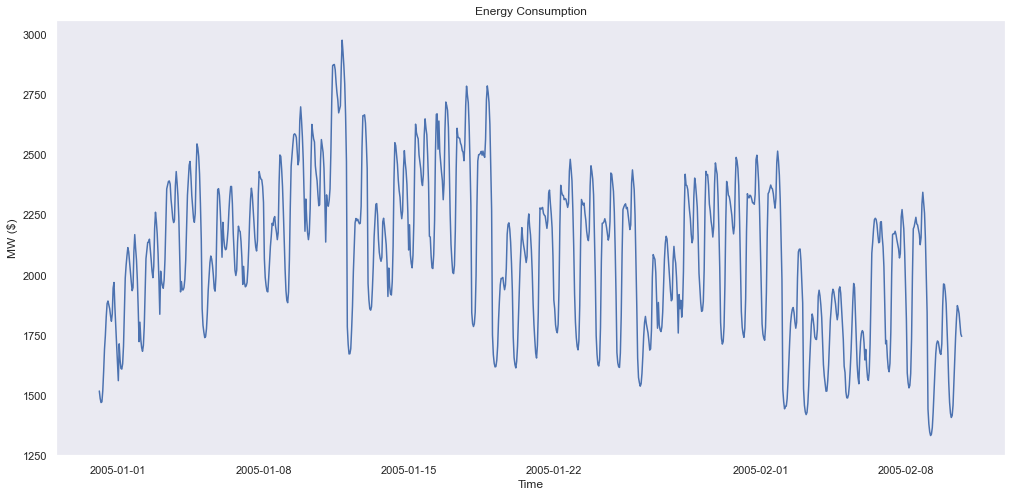

In [4]:
# Plot closing price
plt.figure(figsize=(17, 8))
plt.plot(data.DAYTON_MW[1:1000])
plt.title('Energy Consumption')
plt.ylabel('MW ($)')
plt.xlabel('Time')
plt.grid(False)
plt.show()

In [5]:
#Moving Average
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

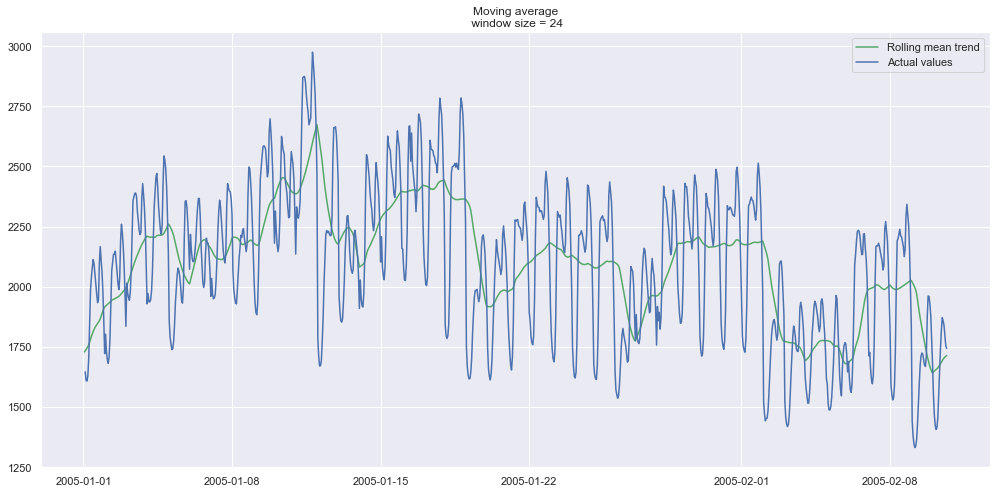

In [6]:
#Smooth by the previous 5 days (by week)
plot_moving_average(data.DAYTON_MW[1:1000], 24)

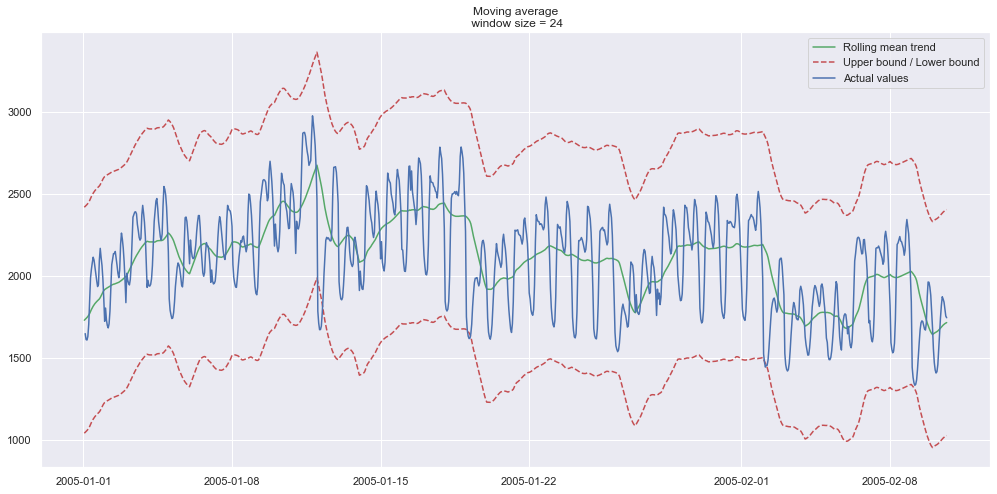

In [7]:
#Smooth by previous quarter (90 days)
plot_moving_average(data.DAYTON_MW[1:1000], 24, plot_intervals=True)

In [8]:
# Exponential smoothing
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [9]:
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

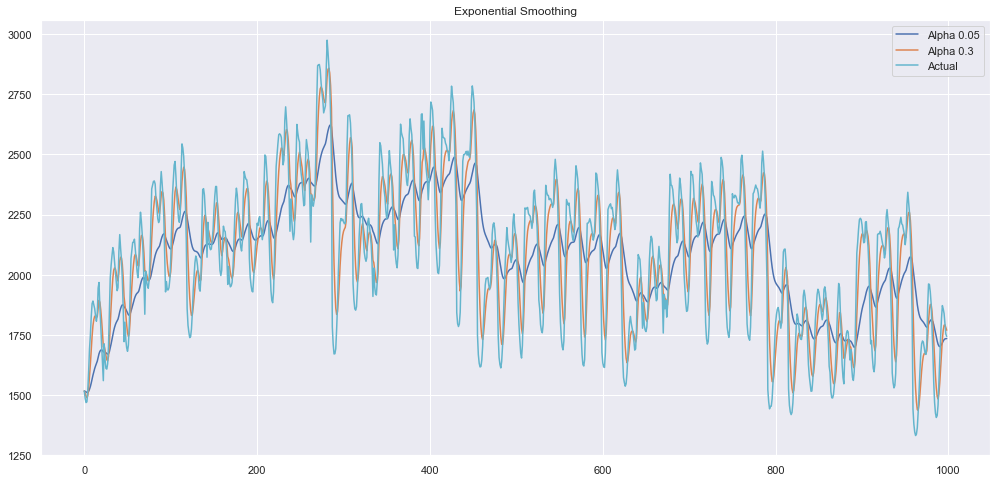

In [10]:
plot_exponential_smoothing(data.DAYTON_MW[1:1000], [0.05, 0.3])

# As you can see, an alpha value of 0.05 smoothed the curve while picking up most of the upward and downward trends.

In [11]:
# Double exponential smoothing
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

In [12]:
def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

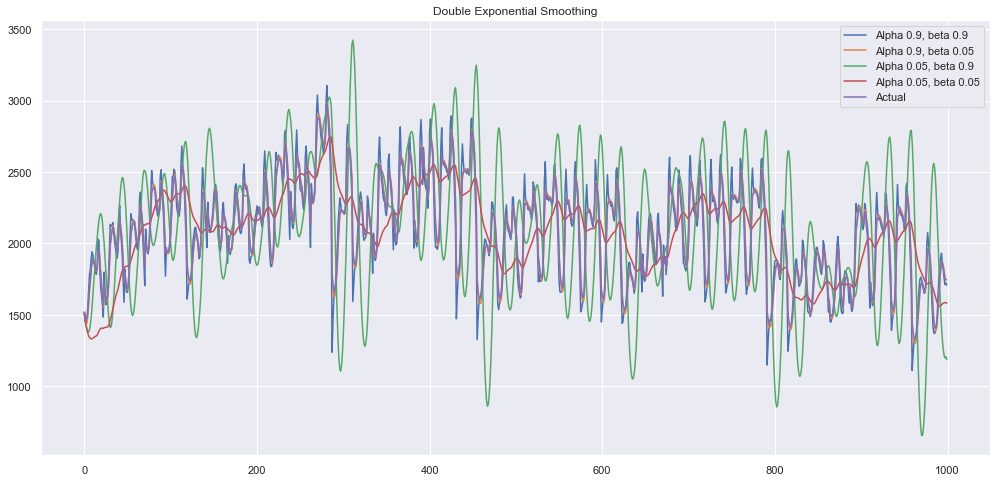

In [13]:
plot_double_exponential_smoothing(data.DAYTON_MW[1:1000], alphas=[0.9, 0.05], betas=[0.9, 0.05])

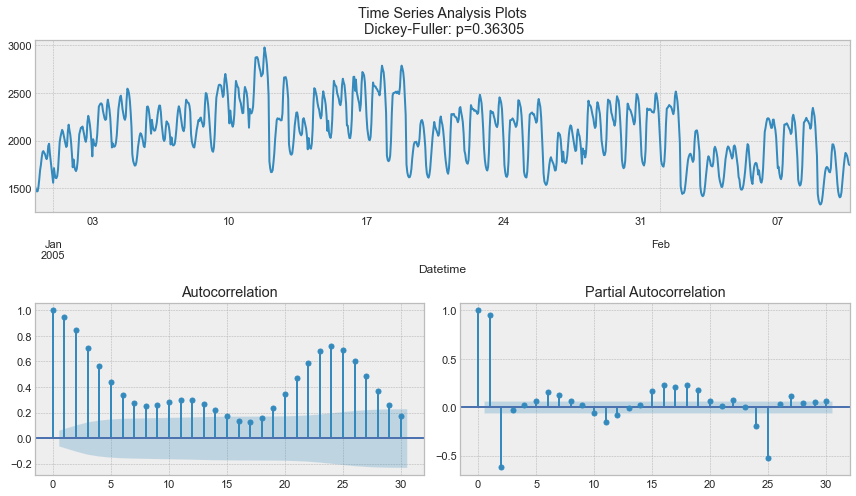

In [14]:
#Modelling
#As outlined previously, we must turn our series into a stationary process in order to model it. Therefore, let’s apply the Dickey-Fuller test to see if it is a stationary process:

# Stationarity
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(data.DAYTON_MW[1:1000], lags=30)

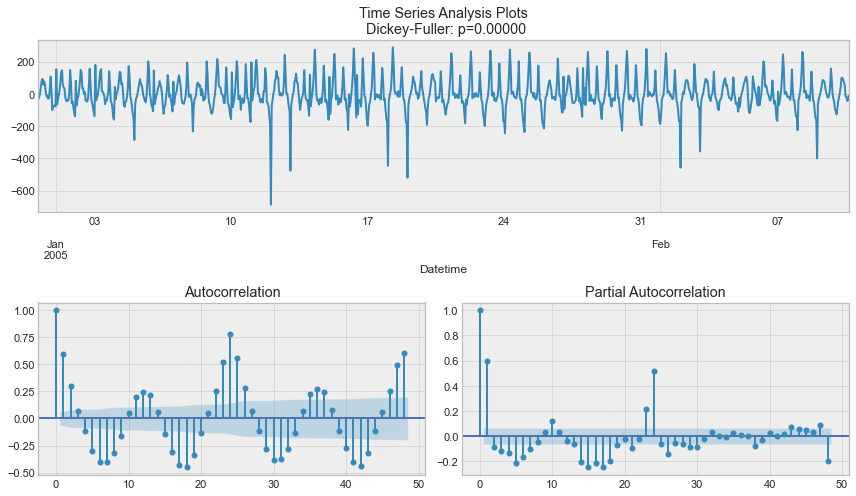

In [15]:
#By the Dickey-Fuller test, the time series is unsurprisingly non-stationary. Also, looking at the autocorrelation plot, we see that it is very high, and it seems that there is no clear seasonality.
#Therefore, to get rid of the high autocorrelation and to make the process stationary, let’s take the first difference (line 23 in the code block). We simply subtract the time series from itself with a lag of one day, and we get:

data_diff = data.DAYTON_MW[1:1000] - data.DAYTON_MW[1:1000].shift(1)

tsplot(data_diff[1:], lags=48)

In [16]:
#SARIMA
#Set initial values and some bounds
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

625

In [17]:
## Train many SARIMA models to find the best set of parameters

def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(data.DAYTON_MW[1:1000], order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
         
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

In [18]:
#Set parameters that give the lowest AIC (Akaike Information Criteria)

p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(data.DAYTON_MW[1:1000], order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                         DAYTON_MW   No. Observations:                  999
Model:             SARIMAX(2, 1, 4)x(0, 1, 4, 5)   Log Likelihood               -5608.396
Date:                           Wed, 14 Oct 2020   AIC                          11238.793
Time:                                   03:16:13   BIC                          11292.701
Sample:                               12-31-2004   HQIC                         11259.289
                                    - 02-10-2005                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7304      0.002   1070.131      0.000       1.727       1.734
ar.L2         -0.9984      0.002   -549.310

In [19]:
def plot_SARIMA(series, model, n_steps):
    """
        Plot model vs predicted values
        
        series - dataset with time series
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
    """
    
    data = series.copy().rename(columns = {'DAYTON_MW[1:1000]': 'actual'})
    data['arima_model'] = model.fittedvalues
    #Make a shift on s+d steps, because these values were unobserved by the model due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    #Forecast on n_steps forward
    forecast = model.predict(start=data.shape[0], end=data.shape[0] + n_steps)
    forecast = data.arima_model.append(forecast)
    #Calculate error
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    
    plt.figure(figsize=(17, 8))
    plt.title('Mean Absolute Percentage Error: {0:.2f}%'.format(error))
    plt.plot(forecast, color='r', label='model')
    plt.axvspan(data.index[-1], forecast.index[-1],alpha=0.5, color='lightgrey')
    plt.plot(data, label='actual')
    plt.legend()
    plt.grid(True);
    
# plot_SARIMA(data, best_model, 12)
print(best_model.predict(start=data.DAYTON_MW[1:1000].shape[0], end=data.DAYTON_MW[1:1000].shape[0] + 12))
print(mean_absolute_percentage_error(data.DAYTON_MW[1:1000][s+d:], best_model.fittedvalues[s+d:]))

2005-02-10 17:00:00    1772.665505
2005-02-10 18:00:00    1828.495926
2005-02-10 19:00:00    1893.576160
2005-02-10 20:00:00    1953.575937
2005-02-10 21:00:00    1991.567652
2005-02-10 22:00:00    1986.405557
2005-02-10 23:00:00    1940.126024
2005-02-11 00:00:00    1869.118702
2005-02-11 01:00:00    1790.184628
2005-02-11 02:00:00    1724.050955
2005-02-11 03:00:00    1681.312672
2005-02-11 04:00:00    1669.302606
2005-02-11 05:00:00    1701.354962
Freq: H, dtype: float64
2.323360084704175


In [20]:
# Compare the predicted consumption to actual data
## Make a dataframe containing actual and predicted consumptions

comparison = pd.DataFrame({'actual': [1761,1859,1889,1844,1797,1742,1649,1545,1653,1560,1538,1529,1557],
                          'predicted': [1772,1828,1893,1953,1991,1986,1940,1869,1790,1724,1681,1669,1701]},
                          index = pd.date_range('2005-02-10 17:00:00', periods=13, freq='60min',))

comparison.head()

,actual,predicted
2005-02-10 17:00:00,1761,1772
2005-02-10 18:00:00,1859,1828
2005-02-10 19:00:00,1889,1893
2005-02-10 20:00:00,1844,1953
2005-02-10 21:00:00,1797,1991


No handles with labels found to put in legend.


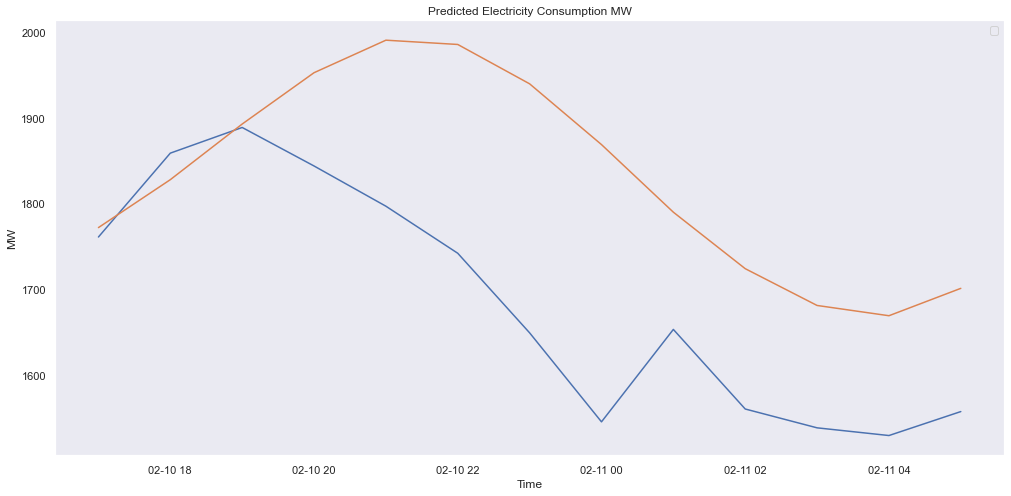

In [21]:
plt.figure(figsize=(17, 8))
plt.plot(comparison.actual)
plt.plot(comparison.predicted)
plt.title('Predicted Electricity Consumption MW')
plt.ylabel('MW')
plt.xlabel('Time')
plt.legend(loc='best')
plt.grid(False)
plt.show()

In [24]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rms = sqrt(mean_squared_error(data.DAYTON_MW[1:1000],forecast))
print("RMSE: ", rms)

NameError: name 'forecast' is not defined